In [1]:
import torch 
import torch.nn as nn
import torch.optim as optim
import torchvision.transforms as transforms
import glob
import numpy as np
from torch.utils.data.sampler import SubsetRandomSampler
from segmentation_dataset import SegmentationDataset
from diceloss import BinaryDiceLoss

train_dir = './suim/train_val/images'
mask_dir = './suim/train_val/masks' 

paths1 = train_dir + "/*.jpg"    
paths2 = mask_dir + "/*.bmp"    

tfiles = glob.glob(paths1)  
mfiles = glob.glob(paths2)  

tfiles.sort()
mfiles.sort()

transform = transforms.Compose([transforms.ToTensor(), transforms.Resize((480,640))])


sds = SegmentationDataset(tfiles, mfiles, transform) 


/home/stefan/.local/lib/python3.6/site-packages/pandas/compat/_optional.py:124: UserWarning: Pandas requires version '1.2.1' or newer of 'bottleneck' (version '1.2.0' currently installed).
  warnings.warn(msg, UserWarning)


In [7]:
class conv_block(nn.Module):
    def __init__(self, in_c, out_c):
        super().__init__()
        self.conv1 = nn.Conv2d(in_c, out_c, kernel_size=3, padding=1)
        self.bn1 = nn.BatchNorm2d(out_c)         
        self.conv2 = nn.Conv2d(out_c, out_c, kernel_size=3, padding=1)
        self.bn2 = nn.BatchNorm2d(out_c)         
        self.relu = nn.ReLU()     
        
    def forward(self, inputs):
        x = self.conv1(inputs)
        x = self.bn1(x)
        x = self.relu(x)        
        x = self.conv2(x)
        x = self.bn2(x)
        x = self.relu(x)
        return x

In [8]:
class encoder_block(nn.Module):
    def __init__(self, in_c, out_c):
        super().__init__()
        self.conv = conv_block(in_c, out_c)
        self.pool = nn.MaxPool2d((2, 2))     
        
    def forward(self, inputs):
        x = self.conv(inputs)
        p = self.pool(x)
        return x, p

In [9]:
class decoder_block(nn.Module):
    def __init__(self, in_c, out_c):
        super().__init__()
        self.up = nn.ConvTranspose2d(in_c, out_c, kernel_size=2, stride=2, padding=0)
        self.conv = conv_block(out_c+out_c, out_c)     
    
    def forward(self, inputs, skip):
        x = self.up(inputs)
        x = torch.cat([x, skip], axis=1)
        x = self.conv(x)
        return x

In [10]:
class unet(nn.Module):
    def __init__(self):
        super().__init__()
        """ Encoder """
        self.e1 = encoder_block(3, 64)
        self.e2 = encoder_block(64, 128)
        self.e3 = encoder_block(128, 256)
        self.e4 = encoder_block(256, 512)         
        
        """ Bottleneck """
        self.b = conv_block(512, 1024)         
        
        """ Decoder """
        self.d1 = decoder_block(1024, 512)
        self.d2 = decoder_block(512, 256)
        self.d3 = decoder_block(256, 128)
        self.d4 = decoder_block(128, 64)         
        
        """ Classifier """
        self.outputs = nn.Conv2d(64, 1, kernel_size=1, padding=0)     
        
    def forward(self, inputs):
        """ Encoder """
        s1, p1 = self.e1(inputs)
        s2, p2 = self.e2(p1)
        s3, p3 = self.e3(p2)
        s4, p4 = self.e4(p3)         
        
        """ Bottleneck """
        b = self.b(p4)         
        
        """ Decoder """
        d1 = self.d1(b, s4)
        d2 = self.d2(d1, s3)
        d3 = self.d3(d2, s2)
        d4 = self.d4(d3, s1)         
        
        """ Classifier """
        outputs = self.outputs(d4)        
        return outputs
    

In [11]:
net = unet()

criterion = BinaryDiceLoss()
optimizer = optim.SGD(net.parameters(), lr=0.001, momentum=0.9)



In [2]:
valid_size = 0.2  # proportion de "train_data" utilisée pour la validation
batch_size = 32   # taille de "batch"

# mélanger aléatoirement train_data et séparer en un jeu d'apprentissage et de validation
num_train = len(tfiles)
indices_train = list(range(num_train))
np.random.shuffle(indices_train)
split_tv = int(np.floor(valid_size * num_train))
train_new_idx, valid_idx = indices_train[split_tv:],indices_train[:split_tv]

In [3]:
# Pour charger les données en GPU automatiquement si disponible (sinon en CPU)
device = 'cuda' if torch.cuda.is_available() else 'cpu'
kwargs = {'num_workers': 1, 'pin_memory': True} if device=='cuda' else {}

# pour échantilloner le jeu de données d'apprentissage (+ validation) de manière uniforme lors de l'apprentissage
train_sampler = SubsetRandomSampler(train_new_idx)
valid_sampler = SubsetRandomSampler(valid_idx)

train_loader = torch.utils.data.DataLoader(sds, batch_size=batch_size, sampler=train_sampler, **kwargs)
valid_loader = torch.utils.data.DataLoader(sds, batch_size=batch_size, sampler=valid_sampler, **kwargs)


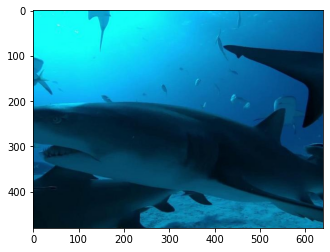

In [8]:
import cv2
import matplotlib.pyplot as plt


it = iter(train_loader)
images = next(it)
i = torch.permute(images[0][0],(1,2,0))
plt.imshow(i)
plt.show()



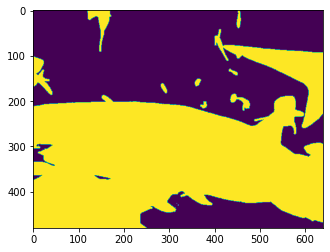

In [9]:
i = images[1][0].squeeze()
plt.imshow(i)
plt.show()


In [ ]:
# Training of classifier

for epoch in range(5):  # loop over the dataset multiple times

    running_loss = 0.0
    for i, data in enumerate(train_loader, 0):
        # get the inputs; data is a list of [inputs, labels]
        inputs, masks = data

        # zero the parameter gradients
        optimizer.zero_grad()

        # forward + backward + optimize
        outputs = net(inputs)
        loss = criterion(outputs, masks)
        loss.backward()
        optimizer.step()

        # print statistics
        running_loss += loss.item()
        if i % 200 == 199:    # print every 2000 mini-batches
            print('[%d, %5d] loss: %.3f' %
                  (epoch + 1, i + 1, running_loss / 200))
            running_loss = 0.0

print('Finished Training')


RuntimeError: "bitwise_and_cpu" not implemented for 'Float'

In [7]:
images[0]


NameError: name 'images' is not defined

<Figure size 432x288 with 0 Axes>